In [1]:
from fastai import *
from fastai.vision import *
from IPython.core.debugger import set_trace

In [122]:
class CustomImageItemList(ImageItemList):
    def open(self, fn):
        img = fn.reshape(28,28)
        img = np.stack((img,)*3, axis=-1)
        return Image(pil2tensor(img, dtype=np.float32))

    @classmethod
    def from_csv_custom(cls, path:PathOrStr, csv_name:str, header:str='infer', **kwargs)->'ItemList':
        df = pd.read_csv(Path(path)/csv_name, header=header)
        res = super().from_df(df, path=path, cols=0, **kwargs)
        res.items = df.iloc[:,1:].apply(lambda x: x.values, axis=1).values
        return res

In [123]:
tfms = get_transforms(do_flip=False)
data = (CustomImageItemList.from_csv_custom(path='./data', csv_name='train.csv')
                           .random_split_by_pct(.2)
                           .label_from_df(cols='label')
                           #.transform(tfms)
                           .databunch(bs=64, num_workers=0))
                          

In [124]:
learn = create_cnn(data, arch=models.resnet34, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


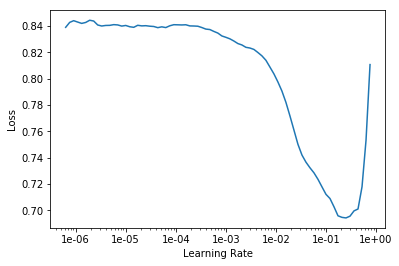

In [125]:
learn.lr_find()
learn.recorder.plot()

In [126]:
lr = 1e-2
learn.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,accuracy


RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'other'